# Environment Setup

In [2]:
# Mounting Drive and authorizing Connection to the GCP's Compute Engine Instance
from google.colab import drive, auth
drive.mount("/content/drive", force_remount=True)
auth.authenticate_user()  # If you running this code and you're using free instance, you don't need this line

Mounted at /content/drive


In [3]:
# Get the data from kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/"Colab Notebooks"/kaggle/kaggle.json ~/.kaggle/kaggle.json
!pip install kaggle
!kaggle competitions download -c h-and-m-personalized-fashion-recommendations
!unzip -qo h-and-m-personalized-fashion-recommendations.zip
!rm h-and-m-personalized-fashion-recommendations.zip # delete saved zip to save disk space

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 28.7G/28.7G [20:27<00:00, 25.6MB/s]
100% 28.7G/28.7G [20:27<00:00, 25.1MB/s]


# Importing the necessary libraries

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from keras.applications.xception import Xception, preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Loading the image data and peprocessing with OpenCV (Open Computer Vision library)

In [10]:
class Similarity():
    def __init__(self, image_directory:str, n_samples:int) ->None:
        self.images_directory_path = image_directory
        self.n_samples = n_samples
        self.image_data = []
        self.image_pathnames = []

    def get_image_paths(self):
        """
        Function to Combine Directory Path with individual Image Path
        parameters: path(string) - Path of directory
        returns: image_names(string) - Full Image Path
        """
        self.image_pathnames = []
        path = self.images_directory_path 
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                fullpath = os.path.join(dirname, filename)
                self.image_pathnames.append(fullpath)


    def load_data(self, n_images:int) ->list:
        """
        load n images to use in modeling and similarity computation
        """
        self.get_image_paths()
        self.image_data = self.image_pathnames[:n_images]
        

    def preprocess_image(self,img_path:str) ->np.ndarray:
        """
        Use openCV to apply the necessary transformations to the image
        """
        dsize = (224,224)
        self.new_image=cv2.imread(img_path)
        self.new_image=cv2.resize(self.new_image,dsize,interpolation=cv2.INTER_NEAREST)  
        self.new_image=np.expand_dims(self.new_image,axis=0)
        self.new_image=preprocess_input(self.new_image)

    def initialize_model(self):
        self.model=Xception(weights='imagenet',include_top=False)
        # Training process is frozen to use the default weights
        for layer in self.model.layers:
            layer.trainable=False

    def extract_features(self, image_data) -> np.array:
        # extract the features of the image
        self.initialize_model()
        self.features= self.model.predict(image_data)
        self.features=np.array(self.features)
        self.features=self.features.flatten()

    def cosine_similarity(self, feature_vector, new_img):
        new_feature = self.model.predict(new_img)
        new_feature = np.array(new_feature)
        new_feature = new_feature.flatten()
        N_result = 12
        nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
        distances, indices = nbrs.kneighbors([new_feature])
        return(indices)

    def show_input(self, data):
        plt.title("Product Image")
        plt.imshow(data)
        
    def show_recommendations(self, data, result):
        fig = plt.figure(figsize=(12,8))
        for i in range(0,12):
            index_result=result[0][i]
            plt.subplot(3,4,i+1)
            plt.imshow(cv2.imread(data[index_result]))
        plt.show()

    def run_results(self):  
        features = []
        self.load_data(n_images=10000)
        sample_query_list = random.sample(range(0, 1000), self.n_samples)  # randomly select sample reference/query products
        
        #Use limited data in training for fast process
        for image in self.image_data[:2000]:
            self.preprocess_image(image)
            self.extract_features(self.new_image)
            features.append(self.features)
        feature_vec = np.array(features)
        
        for query_index in sample_query_list:
            self.preprocess_image(self.image_data[query_index])          # generate new preprocessed image
            result=self.cosine_similarity(feature_vec, self.new_image)
            self.show_input(cv2.imread(self.image_data[query_index]))
            self.show_recommendations(self.image_data,result)

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 1s 999ms/step


1/1 [==============================] - 0s 410ms/step


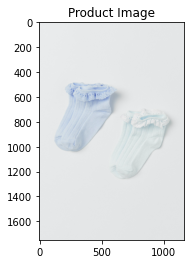

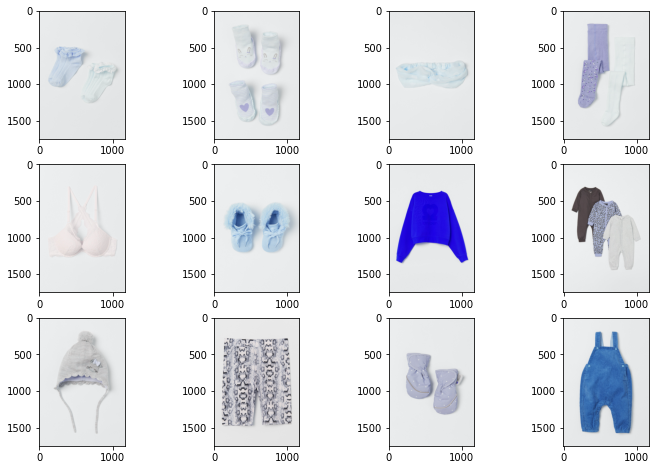

1/1 [==============================] - 0s 228ms/step


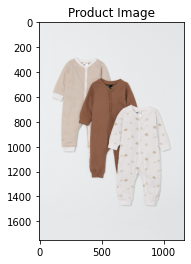

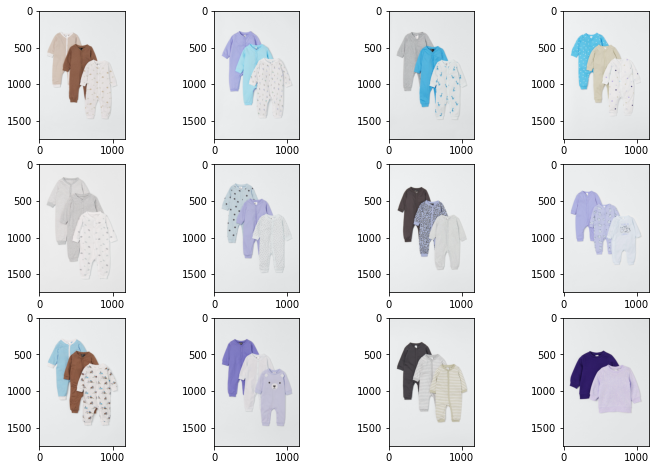

1/1 [==============================] - 0s 290ms/step


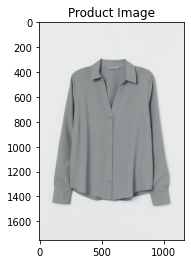

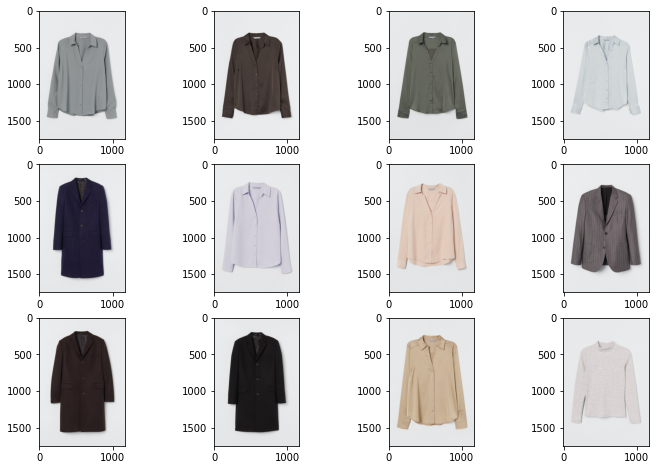

1/1 [==============================] - 0s 241ms/step


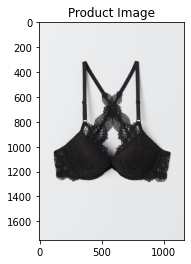

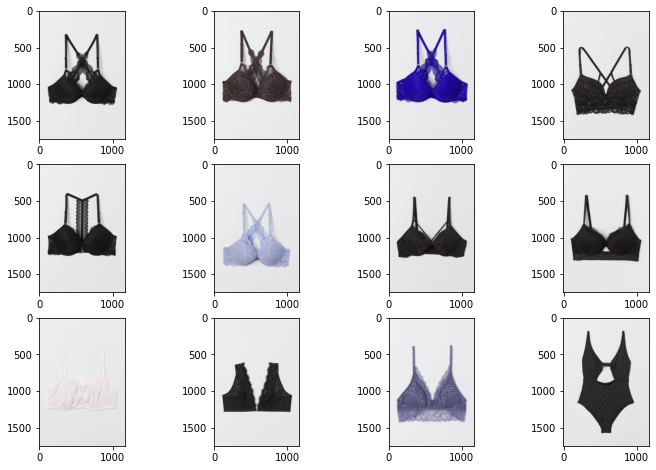

1/1 [==============================] - 0s 252ms/step


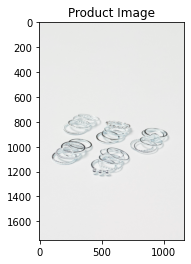

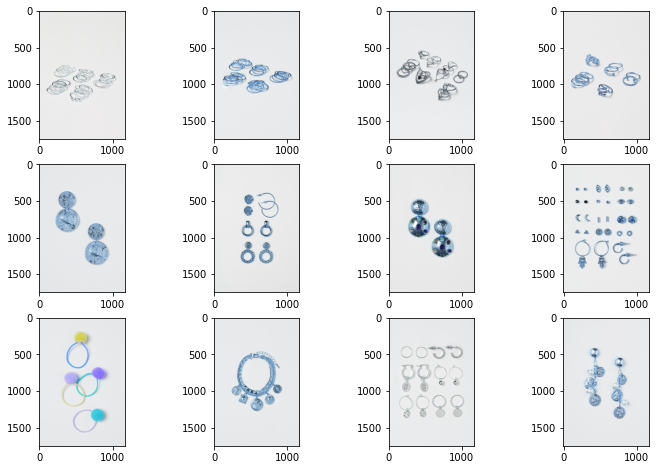

1/1 [==============================] - 0s 282ms/step


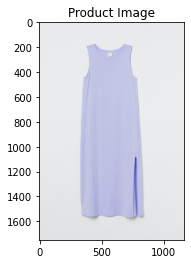

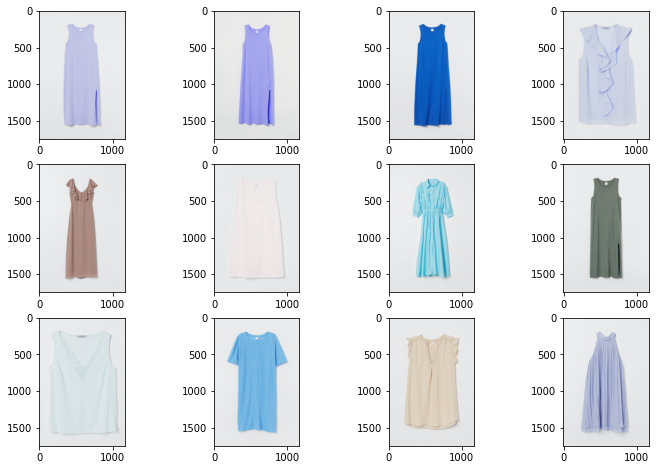

1/1 [==============================] - 0s 256ms/step


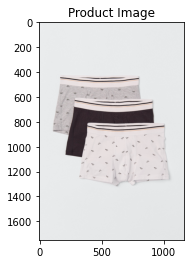

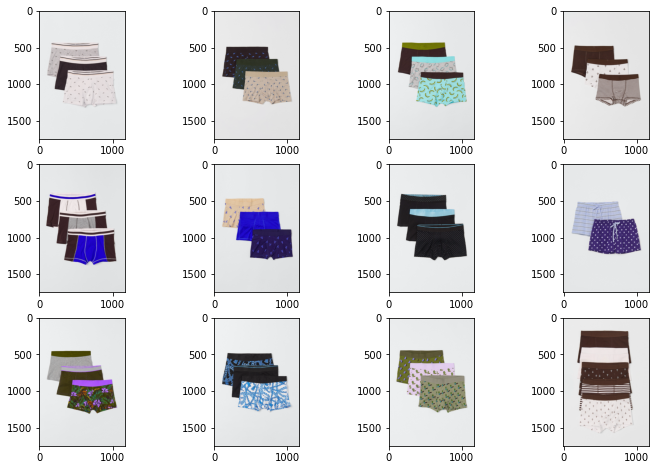

1/1 [==============================] - 0s 237ms/step


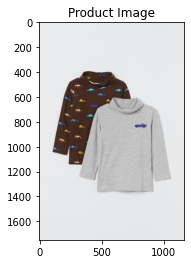

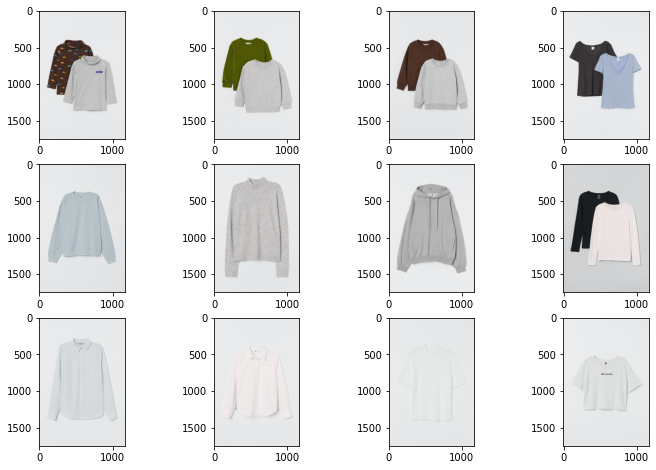

1/1 [==============================] - 0s 400ms/step


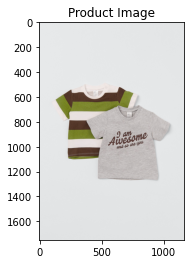

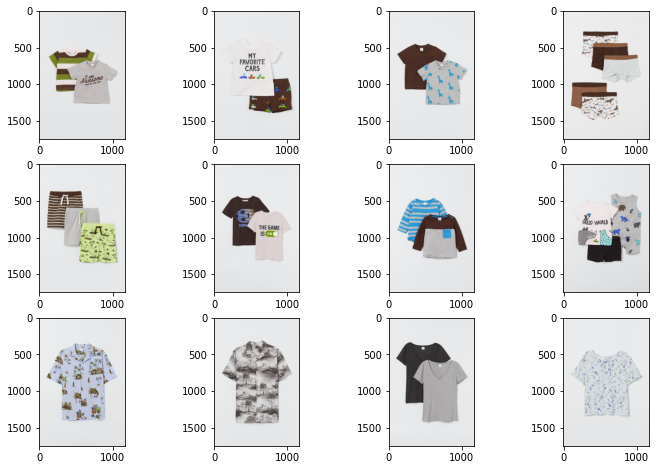

1/1 [==============================] - 0s 232ms/step


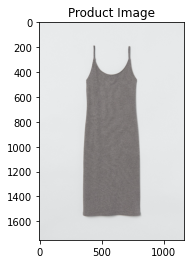

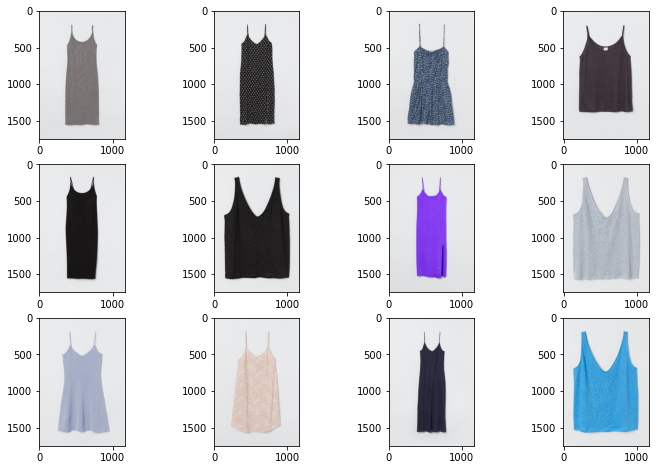

In [11]:
image_data_dir = './images'    # directory containing images
nbr_of_samples = 10            # number of sample recommendations to display

# instantiate a class object
similarity = Similarity(image_directory=image_data_dir,
                        n_samples=nbr_of_samples)

similarity.run_results()